In [210]:
import os

import re
import string

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

In [232]:
def read_text_files_into_dataframe(data_folder : str):
    """
    Function reads text files from specified data folder and saves them as dataframe

    Args:
        data_folder - path to folder with text data
    """

    texts = []  # List to store the text data
    labels = []  # List to store the corresponding labels
    split = [] # List to store information about split

    # For each file in the data folder
    for file_name in os.listdir(data_folder):

        # Specify whether it is training or test part
        split_name = 'train' if file_name.startswith('training') else 'test'

        file_path = os.path.join(data_folder, file_name)

        # Read from text file
        with open(file_path, 'r', encoding='utf-8') as file:
            if file_name.endswith('text.txt'):
                read_texts = file.read().split("\n")
                texts = texts + read_texts
                split = split + [split_name] * len(read_texts)

            elif file_name.endswith('tags.txt'):
                labels = labels + file.read().split("\n")
            
            else:
                raise Exception("Not implemented error!")
            
       
    # Create a pandas DataFrame
    df = pd.DataFrame({'text': texts, 'label': labels, 'split': split})
    
    return df

def encoded_special_signs(text : str, clean : bool = False):
    """
    Function checks if text contains emojis and how many

    Args:
        text - text to check
        clean - if emojis should be cleaned
    """

    # Define polish letters
    pl_letters = 'ą ć ę ł ń ó ś ź ż'
    
    # Create list of special signs in text
    special_signs = [l for l in text.lower() if l not in list(string.ascii_lowercase) and l not in set(string.punctuation) and l not in [' ', '  '] and l.isdigit() == False]
    
    # Create list of encoded special signs
    special_signs_encoded = [l.encode() for l in special_signs]
    
    # Create list of True/False values checking if given special sign is emoji
    is_emoji = [l not in pl_letters.encode().split() for l in special_signs_encoded]

    if clean:
        
        emojis = list(pd.Series(special_signs)[is_emoji])
        
        for e in emojis:
            text = text.replace(e, '')

        return sum(is_emoji), text
    
    return sum(is_emoji)

def clean_text(text):
    """
    Function clean texts from special signs, emojis and mentions
    
    Args:
        text - text to be cleaned
    """

    # Remove emojis
    text = encoded_special_signs(text, clean=True)[1]

    # Remove mentions
    text = text.replace('@anonymized_account', '')

    # Remove special characters
    for p in set(string.punctuation):
        
        text = text.replace(p, ' ')

    # Remove double spaces
    text = re.sub(' +', ' ', text)

    # Remove forward and backward spaces
    text = text.strip()

    return text

def update_seaborn_plot_labels_title(plot, xlabel=None, ylabel=None, title=None, legend=None):
    """
    Function to update x-axis label, y-axis label, and title of a Seaborn plot.
    
    Args:
        plot - The Seaborn plot you want to update.
        xlabel - The new label for the x-axis. If not provided, the label remains unchanged.
        ylabel - The new label for the y-axis. If not provided, the label remains unchanged.
        title - The new title for the plot. If not provided, the title remains unchanged.
        legend - The new title for the legend. If note provided, the title remains unchanged. 
    """
    if xlabel is not None:
        plot.set(xlabel=xlabel)
    if ylabel is not None:
        plot.set(ylabel=ylabel)
    if title is not None:
        plot.set(title = title)
    if legend is not None:
        plot._legend.set_title(legend)

In [3]:
# Create dataframe with text data
df = read_text_files_into_dataframe("data")

# Get train and test data
train, test = df.loc[df.split == 'train', ['text', 'label']], df.loc[df.split == 'train', ['text', 'label']]

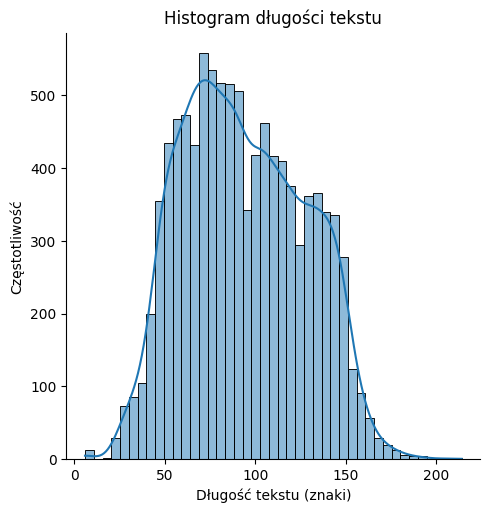

In [230]:
train['length'] = train.text.apply(lambda row: len(row))
plot = sns.displot(train.length, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (znaki)', ylabel='Częstotliwość', title='Histogram długości tekstu')
plt.show()

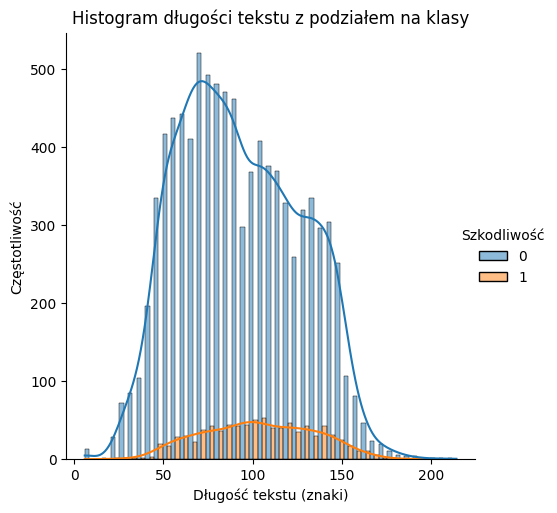

In [234]:
plot = sns.displot(data=train, x='length', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (znaki)', ylabel='Częstotliwość', title='Histogram długości tekstu z podziałem na klasy', legend='Szkodliwość')
plt.show()

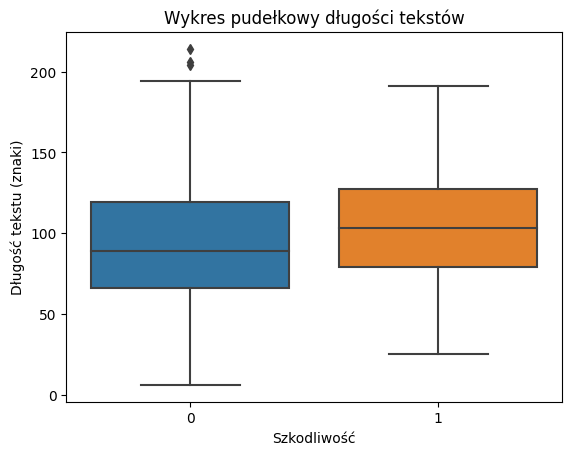

In [235]:
plot = sns.boxplot(y='length', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Długość tekstu (znaki)', title='Wykres pudełkowy długości tekstów')
plt.show()

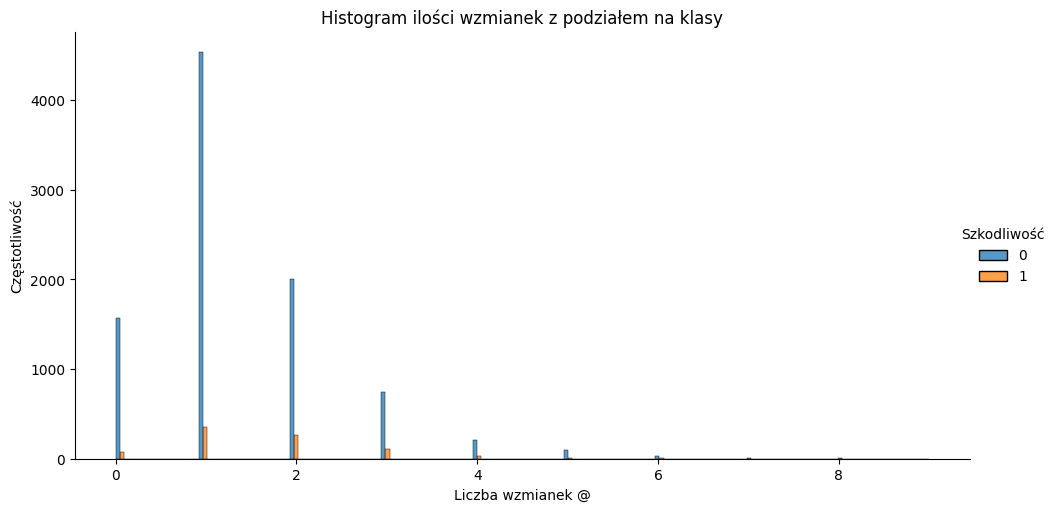

In [236]:
train['n_of_mentions'] = train.text.str.count("@anonymized_account")
plot = sns.displot(data=train, x='n_of_mentions', kde=False, hue='label', multiple='dodge', aspect=2)
update_seaborn_plot_labels_title(plot, xlabel='Liczba wzmianek @', ylabel='Częstotliwość', title='Histogram ilości wzmianek z podziałem na klasy', legend='Szkodliwość')
plt.show()

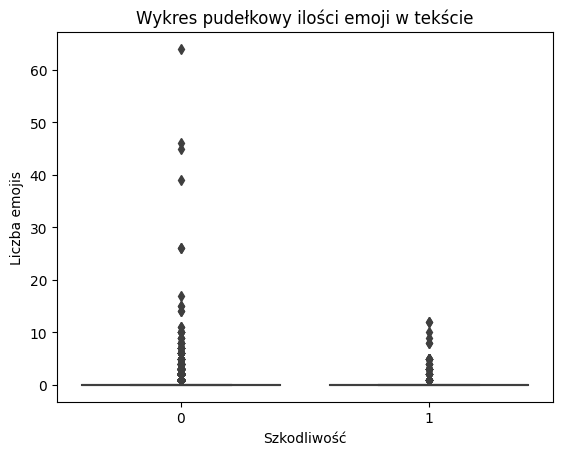

In [237]:
train['emojis'] = train.text.apply(lambda row: encoded_special_signs(row))
plot = sns.boxplot(y='emojis', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Liczba emojis', title='Wykres pudełkowy ilości emoji w tekście')
plt.show()

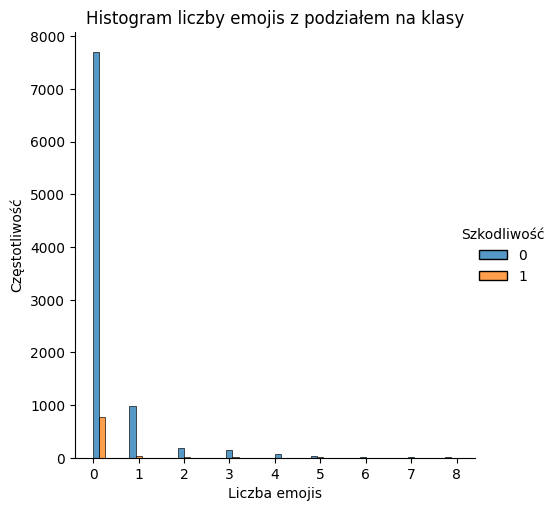

In [238]:
plot = sns.displot(data=train[train.emojis <= 8], x='emojis', kde=False, hue='label', multiple='dodge', bins=30)
update_seaborn_plot_labels_title(plot, xlabel='Liczba emojis', ylabel='Częstotliwość', title='Histogram liczby emojis z podziałem na klasy', legend='Szkodliwość')
plt.show()

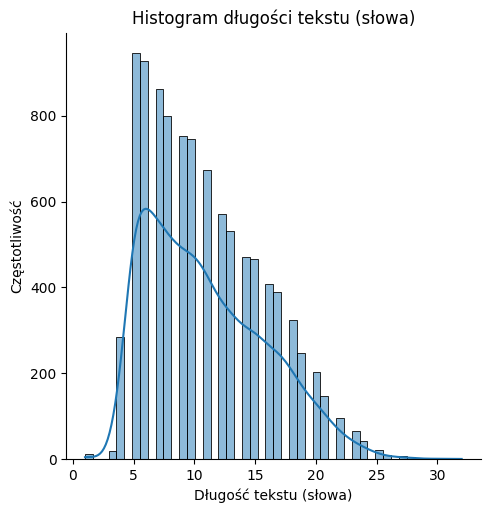

In [239]:
train['text_cleaned'] = train.text.apply(lambda row: clean_text(row))
train['word_length_cleaned'] = train.text_cleaned.apply(lambda row: len(row.split()))
plot = sns.displot(train.word_length_cleaned, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (słowa)', ylabel='Częstotliwość', title='Histogram długości tekstu (słowa)')
plt.show()

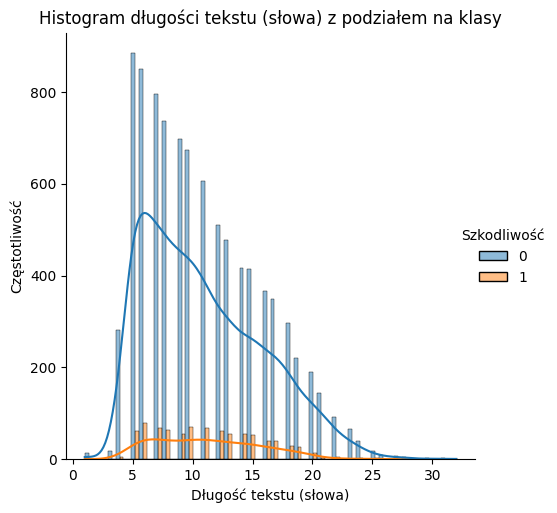

In [241]:
plot = sns.displot(data=train, x='word_length_cleaned', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (słowa)', ylabel='Częstotliwość', title='Histogram długości tekstu (słowa) z podziałem na klasy', legend='Szkodliwość')
plt.show()

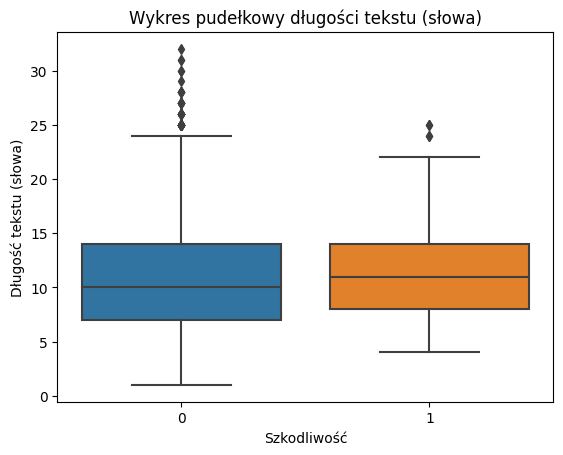

In [240]:
plot = sns.boxplot(y='word_length_cleaned', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Długość tekstu (słowa)', title='Wykres pudełkowy długości tekstu (słowa)')
plt.show()